# NLP sentiment analysis and topic modeling

In [ ]:
!pip install bertopic
#!pip install flair

import pandas as pd
from bertopic import BERTopic
import plotly.express as px
import re

In [ ]:
# load data

#import io
data = pd.read_csv("dat.csv")

In [ ]:
data.tail(20)

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
9251,Konstantin F. Prinz,Showing my kids how to outsource homework to a...,"Como, Lombardy","fast thinker, builder of products, car and tec...",2008-04-22 13:31:18+00:00,134.0,265.0,121,False,2022-12-05 19:41:54+00:00,"['ChatGPT', 'OpenAI']",Twitter for iPad
9252,Zxhra,I wonder if/how #ChatGPT can be leveraged for ...,"London, England","Product designer by day ✨ Powered by empathy, ...",2022-11-15 02:29:27+00:00,12.0,50.0,164,False,2022-12-05 19:28:07+00:00,['ChatGPT'],Twitter for Android
9253,this is me,Learning Algorithm — make a list of questions ...,"Kiev, Ukraine",NaN,2009-06-26 05:32:21+00:00,762.0,162.0,1094,False,2022-12-05 19:19:21+00:00,['ChatGPT'],Twitter for iPhone
9254,Peyman Bateni,Some #ChatGPT wisdom for us at @beamhealthai. ...,"Vancouver, British Columbia",Tackling the stress epidemic with @beamhealtha...,2013-08-14 07:01:10+00:00,181.0,134.0,388,False,2022-12-05 19:15:18+00:00,['ChatGPT'],Twitter Web App
9255,Hacker News,AI Homework\n\n#answers #information #homework...,NaN,Official twitter BOT of https://t.co/kOCw5xEqi...,2021-10-17 16:37:58+00:00,191.0,1.0,0,False,2022-12-05 19:10:52+00:00,"['answers', 'information', 'homework', 'model'...",Hacker__News
9256,Joseph Luna,Learning things with #ChatGPT is the closest t...,"Cleveland, OH",Assistant Professor of Biochemistry @CWRUSOM a...,2020-02-20 00:07:59+00:00,546.0,566.0,1180,False,2022-12-05 19:09:07+00:00,['ChatGPT'],Twitter for iPhone
9257,Nikola Stikov,"My favorite speculative fiction writer, @Marga...",NaN,Professor @PolyMTL @PolyNeuro rethinking the f...,2009-04-18 02:47:00+00:00,3051.0,1174.0,6807,False,2022-12-05 19:02:10+00:00,NaN,Twitter Web App
9258,Faiz Shah,An interesting limitation of #ChatGPT is that ...,NaN,annoying tech guy,2019-01-16 20:54:43+00:00,23.0,413.0,428,False,2022-12-05 18:48:30+00:00,['ChatGPT'],Twitter for iPad
9259,David Robinson,Asked #ChatGPT the #ai ‘what are some of the c...,"North East, England",Teacher. Middle Leader. Avid reader. Linguisti...,2011-06-14 17:00:24+00:00,174.0,421.0,368,False,2022-12-05 18:32:55+00:00,"['ChatGPT', 'ai']",Twitter for iPhone
9260,"pollodumas ᵍᵐ (💙,🧡) Ξ 🦇🔊",This means that #chatgpt can understand the co...,Blockchain,Entrepreneur | Curious by nature | Maxi Defi |...,2012-01-26 15:07:20+00:00,756.0,3989.0,27533,False,2022-12-05 18:24:22+00:00,['chatgpt'],Twitter Web App


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9271 entries, 0 to 9270
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_name         9271 non-null   object 
 1   text              9271 non-null   object 
 2   user_location     7416 non-null   object 
 3   user_description  8887 non-null   object 
 4   user_created      9271 non-null   object 
 5   user_followers    9271 non-null   float64
 6   user_friends      9271 non-null   float64
 7   user_favourites   9271 non-null   int64  
 8   user_verified     9271 non-null   bool   
 9   date              9271 non-null   object 
 10  hashtags          6521 non-null   object 
 11  source            9271 non-null   object 
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 805.9+ KB


In [ ]:
(data.isnull().sum() / len(data)) * 100

index        0.000000
user_name    0.002285
text         0.000000
dtype: float64

<font color='red'>We see some columns having too many missing values. We will drop those.</font>

In [ ]:
# del data['id']
# del data['author_flair_text']
# del data['removed_by']
# del data['total_awards_received']
# del data['awarders']
# del data['created_utc']
# del data['full_link']

In [ ]:
# Drop the columns where at least one element is missing
data = data.dropna()

In [ ]:
data.head()

,index,user_name,text,prep
0,0,س18,"AI, is the tool we built to surpass ourselves,...","AI, is the tool we built to surpass ourselves,..."
1,1,Kelvin Gandhi👨‍💻,"these twitter threads 👇👇, \n\n“99% people don’...","these twitter threads 👇👇, \n\n“99% people don’..."
2,2,Brenda Christensen,"Listening to ""Ep 2. StrikeReady on AI's Virtua...","Listening to ""Ep 2. StrikeReady on AI's Virtua..."
3,3,Daniel Burstein,Marketing Funnel: Proven strategies for genera...,Marketing Funnel: Proven strategies for genera...
4,4,inKstall Educare,Exciting news! Just published: Integrating Cha...,Exciting news! Just published: Integrating Cha...


Now we have only the relevant information and no missing values.

# Natural Language Processing

## Sentiment Analysis

In [ ]:
def remove_mentions_and_links(text):
    new_text = []
    for t in text.split(" "):
        t = "" if (t.startswith('@') or t.startswith('#') ) and len(t) > 1 else t
        new_text.append(t)

    new_text = re.sub(r'http\S+', '', " ".join(new_text))
    return new_text

data["prep"] = data.text.apply(remove_mentions_and_links)
data = data.reset_index(drop=True)

## Topic Modeling

https://deepgram.com/learn/python-topic-modeling-with-a-bert-model

https://www.pinecone.io/learn/bertopic/

In [ ]:
def words_only(text):
    regex=u"[a-zA-Z\.\?!:;\-']+"
    regex = re.compile(regex)
    return " ".join(regex.findall(text))

def basic_preprocessing(texts):
    texts = texts.str.replace("https:","")
    texts = texts.str.replace("t.co","")
    # remove tel and email
    texts = texts.str.replace("<email>","")
    texts = texts.str.replace("<tel>","")
    texts = texts.str.replace("<link>","")
    texts = [re.sub(r'anon\d*',"",t) for t in texts]
    # Remove new line characters
    texts = [re.sub('\s+', ' ', t) for t in texts]
    # Remove single quotes
    texts = [re.sub("\'", "", sent) for sent in texts]
    # remove some punctuation and numbers, emoji
    texts = [words_only(t.lower()).strip() for t in texts]

    return texts

In [ ]:
data.prep = basic_preprocessing(data.prep)
data.prep = data.prep.str.replace("chatgpt","")

In [ ]:
data = data.loc[data.prep !=""]
print("Non-empty tweets in English: ", data.shape[0])

Non-empty tweets in English:  9269


(-0.5, 1599.5, 799.5, -0.5)

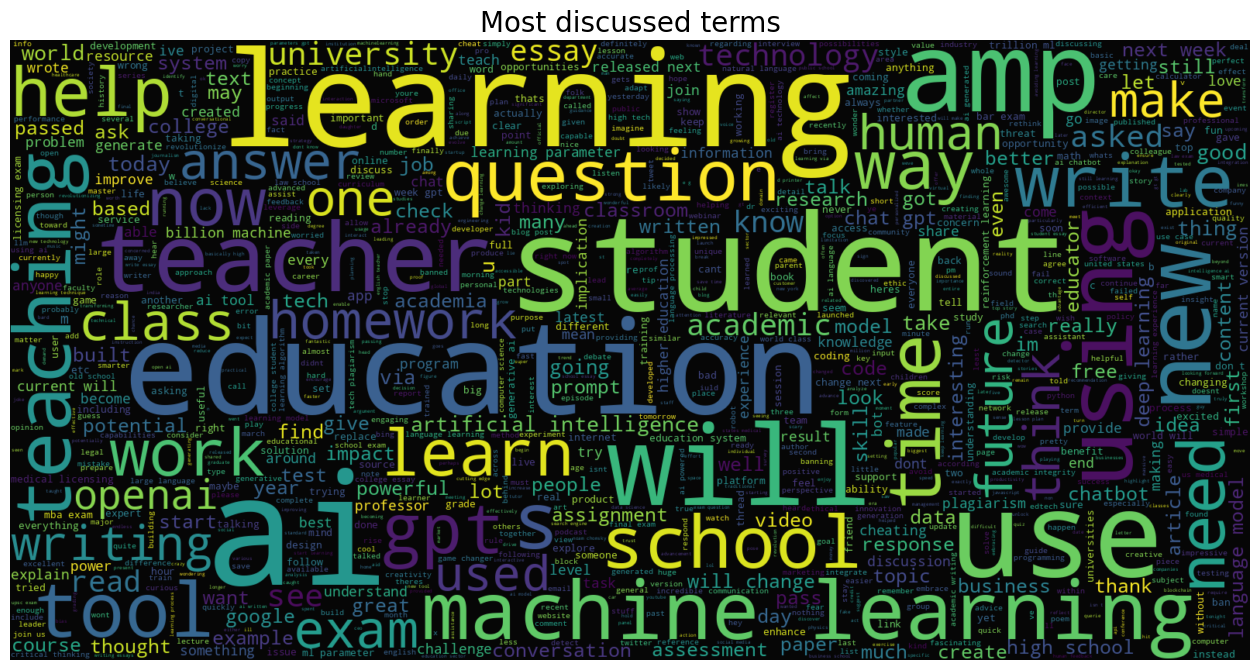

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

words = data["prep"].values
ls = []
for i in words:
    ls.append(str(i))

# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer
#from flair.embeddings import TransformerDocumentEmbeddings


def topic_modelling(text_prep):
    docs=list(text_prep)
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    #roberta = TransformerDocumentEmbeddings("cardiffnlp/twitter-roberta-base-sep2022")
    #model=BERTopic(embedding_model=roberta,ctfidf_model=ctfidf_model,n_gram_range = (1,2),verbose=True,language='English',low_memory=True,min_topic_size=100)
    model=BERTopic(ctfidf_model=ctfidf_model,n_gram_range = (1,2),verbose=True,language='English',low_memory=True,min_topic_size=30)
    topics=model.fit_transform(docs)
    new_topics = model.reduce_outliers(docs,topics[0])
    model.update_topics(docs, topics=new_topics)
    topic_info=model.get_topic_info()
    return model.topics_, topic_info,model

In [ ]:
data["topics"],topic_info,model = topic_modelling(data["prep"])

Batches:   0%|          | 0/290 [00:00<?, ?it/s]

2023-08-28 11:15:52,735 - BERTopic - Transformed documents to Embeddings
2023-08-28 11:16:16,533 - BERTopic - Reduced dimensionality
2023-08-28 11:16:17,346 - BERTopic - Clustered reduced embeddings
100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


In [ ]:
data.to_pickle("../content/topics.pkl")
topic_info.to_excel("../content/topic_info_bert.xlsx")
data.loc[:,["user_name","text","prep","topics"]].sample(100).to_excel("../content/sample_topic_bert.xlsx")
model.save("../content/model_bertopic")

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2,-1_unroll___,"[unroll, , , , , , , , , ]",[has your school issued an official stance on ...
1,0,1316,0_ai_and_to_the,"[ai, and, to, the, of, in, education, is, how,...",[ai like have the potential to change the worl...
2,1,423,1_chatbot_and_to_is,"[chatbot, and, to, is, of, the, learning, ai, ...",[ is a chatbot launched by openai in november ...
3,2,364,2_gpt_chat_chat gpt_to,"[gpt, chat, chat gpt, to, is, and, the, it, wi...",[chat gpt- which is times powerful than . will...
4,3,491,3_writing_write_to_the,"[writing, write, to, the, essays, essay, for, ...",[just realizing what and did to every english ...
5,4,482,4_learning_it_to_is,"[learning, it, to, is, the, and, you, for, thi...",[had a chat with my friend on the other side o...
6,5,352,5_code_to_learning_it,"[code, to, learning, it, and, me, for, with, i...",[- creating nerf software with this is so incr...
7,6,455,6_education_the_and_of,"[education, the, and, of, in, is, to, system, ...",[lol ! makes me laugh so hard at the education...
8,7,254,7_amp_to_the_in,"[amp, to, the, in, for, on, of, it, about, this]",[googles amp; other tools are revolutionizing ...
9,8,191,8_openai_the_and_learning,"[openai, the, and, learning, ai, to, of, is, i...",[openai has released a powerful new image- and...


In [ ]:
model.visualize_hierarchy(top_n_topics=None)